In [88]:
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# matplotlib is required for this example
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4,4)

In [89]:
import energyflow as ef
from matplotlib import animation, rc

In [90]:
# helper function to interpolate between the optimal transport of two events
def merge(ev0, ev1, R=1, lamb=0.5):    
    emd, G = ef.emd.emd(ev0, ev1, R=R, return_flow=True)

    merged = []
    for i in range(len(ev0)):
        for j in range(len(ev1)):
            if G[i, j] > 0:
                merged.append([G[i,j], lamb*ev0[i,1] + (1-lamb)*ev1[j,1], 
                                       lamb*ev0[i,2] + (1-lamb)*ev1[j,2]])

    # detect which event has more pT
    if np.sum(ev0[:,0]) > np.sum(ev1[:,0]):
        for i in range(len(ev0)):
            if G[i,-1] > 0:
                merged.append([G[i,-1]*lamb, ev0[i,1], ev0[i,2]])
    else:
        for j in range(len(ev1)):
            if G[-1,j] > 0:
                merged.append([G[-1,j]*(1-lamb), ev1[j,1], ev1[j,2]])            

    return np.asarray(merged)

In [91]:
#############################################################
# LOAD IN JETS
#############################################################
specs = ['375 <= corr_jet_pts <= 425', 'abs_jet_eta < 1.9', 'quality >= 2']
events = ef.mod.load(*specs, dataset='cms', amount=0.01)

# events go here as lists of particle [pT,y,phi]
event0 = events.particles[14930][:,:3]
event1 = events.particles[19751][:,:3]

# center the jets
event0[:,1:3] -= np.average(event0[:,1:3], weights=event0[:,0], axis=0)
event1[:,1:3] -= np.average(event1[:,1:3], weights=event1[:,0], axis=0)

# mask out particles outside of the cone
event0 = event0[np.linalg.norm(event0[:,1:3], axis=1) < R]
event1 = event1[np.linalg.norm(event1[:,1:3], axis=1) < R]

ev0 = np.copy(event0)
ev1 = np.copy(event1)

In [92]:
#############################################################
# ANIMATION OPTIONS
#############################################################
zf = 2           # size of points in scatter plot
lw = 1           # linewidth of flow lines
fps = 40         # frames per second, increase this for sharper resolution
nframes = 10*fps # total number of frames
R = 0.5          # jet radius

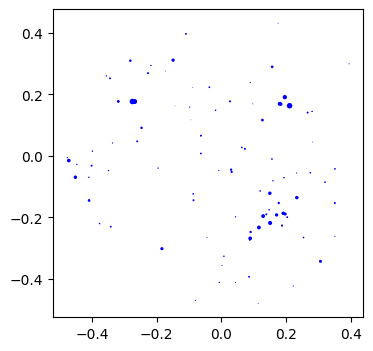

In [93]:
#############################################################
# MAKE ANIMATION
#############################################################

fig, ax = plt.subplots()

# Why do we merge 2 events here?
merged = merge(ev0, ev1, lamb=0, R=R)

pts, ys, phis = merged[:,0], merged[:,1], merged[:,2]

# Make scatter plot in rapidity-phi plane and pT corresponds to the size of the points and print
scatter = ax.scatter(ys, phis, color='blue', s=pts, lw=0)

# animation function. This is called sequentially
def animate(i):
    ax.clear()

    nstages = 4

    # first phase is a static image of event0
    if i < nframes / nstages:
        lamb = nstages*i/(nframes-1)
        ev0  = event0
        ev1  = event0
        color = (1,0,0)

    # second phase is a transition from event0 to event1
    elif i < 2 * nframes / nstages:
        lamb = nstages*(i - nframes/nstages)/(nframes-1)
        ev0  = event1
        ev1  = event0
        color = (1-lamb)*np.asarray([1,0,0]) + (lamb)*np.asarray([0,0,1])

    # third phase is a static image of event1
    elif i < 3 * nframes / nstages:
        lamb = nstages*(i - 2*nframes/nstages)/(nframes-1)
        ev0  = event1
        ev1  = event1
        color = (0,0,1)

    # fourth phase is a transition from event1 to event0
    else:
        lamb = nstages*(i - 3*nframes/nstages)/(nframes-1)
        ev0  = event0
        ev1  = event1
        color = (lamb)*np.asarray([1,0,0]) + (1-lamb)*np.asarray([0,0,1])

    merged = merge(ev0, ev1, lamb=lamb, R=0.5)
    pts, ys, phis = merged[:,0], merged[:,1], merged[:,2]
    scatter = ax.scatter(ys, phis, color=color, s=zf*pts, lw=0)

    ax.set_xlim(-R, R); ax.set_ylim(-R, R);
    ax.set_axis_off()

    return scatter,

In [94]:
anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=True)

In [95]:
anim.save('energyflowanimation.mp4', fps=fps, dpi=200)

In [96]:
from IPython.display import HTML
HTML(anim.to_html5_video())

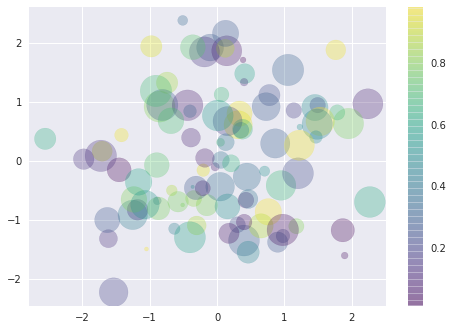

In [47]:
rng = np.random.RandomState(0)
x = rng.randn(100)
y = rng.randn(100)
colors = rng.rand(100)
sizes = 1000 * rng.rand(100)

plt.scatter(x, y, c=colors, s=sizes, alpha=0.3,
            cmap='viridis')
plt.colorbar();  # show color scale

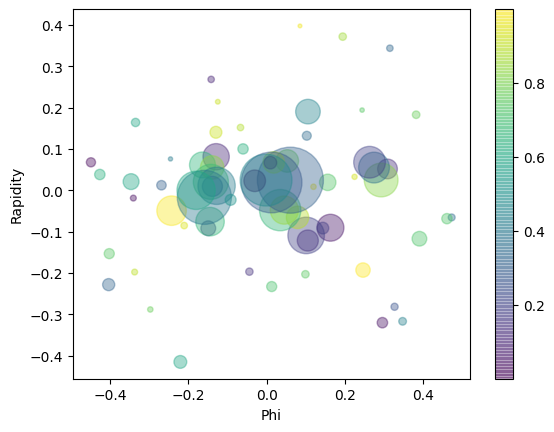

In [87]:
event0 = events.particles[10001][:,:3]
event0[:,1:3] -= np.average(event0[:,1:3], weights=event0[:,0], axis=0)
event0 = event0[np.linalg.norm(event0[:,1:3], axis=1) < R]

pts_plot, ys_plot, phis_plot = event0[:,0], event0[:,1], event0[:,2]

colors = rng.rand(phis_plot.shape[0]) # would be nicer with e.g. only shades of green and blue or so

plt.scatter(phis_plot, ys_plot, c=colors, s=50*pts_plot, alpha=0.4,
            cmap='viridis')
plt.xlabel('Phi')
plt.ylabel('Rapidity')
plt.colorbar();  # show color scale

In [78]:
plt.rcdefaults() 

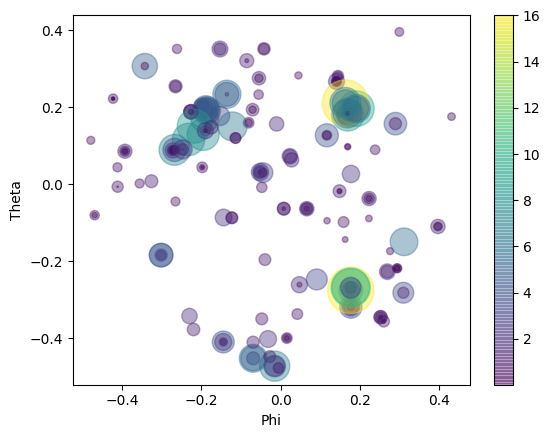

In [80]:
colors = rng.rand(phis.shape[0])

plt.scatter(phis, ys, c=pts, s=70*pts, alpha=0.4,
            cmap='viridis')
plt.xlabel('Phi')
plt.ylabel('Theta')
plt.colorbar();  # show color scale

In [ ]:
# !!!! Also can make plots (instead of animation) where particles before and after hadronization 
#      are connected by lines
# !!!! Also note that the EMD allows for a definition of how similar events are. We could focus on events where
#      parton & hadron level are very different and design observables which are very sensitive to this topology.

[[379.29897029   0.           0.        ]]


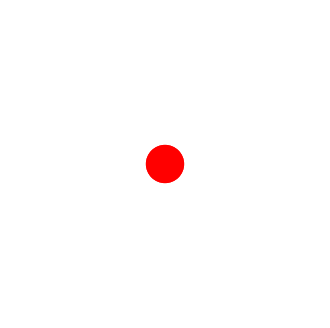

In [107]:
# Next make animation: 1 parton -> jet
event1 = events.particles[10001][:,:3]
event1[:,1:3] -= np.average(event1[:,1:3], weights=event1[:,0], axis=0)
event1 = event1[np.linalg.norm(event1[:,1:3], axis=1) < R]

# Compute pT of the jet
event1pT = np.sum(event1[:,0])

# Set up ``initial parton'' as event1 [probably should be rather event 0 than 1] centered at the origin
event0 = np.array([[event1pT,0,0]])
print(event0)

#############################################################
# MAKE ANIMATION
#############################################################

fig, ax = plt.subplots()

# Why do we merge 2 events here?
merged = merge(event0, event1, lamb=0, R=R)

pts, ys, phis = merged[:,0], merged[:,1], merged[:,2]

# Make scatter plot in rapidity-phi plane and pT corresponds to the size of the points and print
scatter = ax.scatter(ys, phis, color='blue', s=pts, lw=0)

anim_parton_jet1 = animation.FuncAnimation(fig, animate, frames=nframes, repeat=True)
anim_parton_jet1.save('parton_jet1.mp4', fps=fps, dpi=200)

# Note: we could also animate the parton shower if we keep track of all the splittings instead of EMD all at once.